<a href="https://colab.research.google.com/github/kimbob123/LendingClub_ML/blob/main/%5BROE%5D_LC_PipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###전처리

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/EDA/pure_budo.csv')
data.drop(['loan_status', 'ym', 'DATE_x', 'grade', 'sub_grade', 'Unnamed: 0','DATE_y', 'fico_range_low', 'emp_length' ], axis=1, inplace=True)

selected_variables = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_high',
    'mths_since_last_delinq', 'revol_bal', 'revol_util', 'total_acc', 'acc_open_past_24mths',
    'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_il_tl',
    'num_rev_accts', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit', 'GS2', 'UNRATE', 'term', 'collections_12_mths_ex_med',
    'chargeoff_within_12_mths', 'tax_liens' ,'id','defaulter'
]


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/raw_raw/lending_club_2020_train.csv')
raw_data['defaulter'] = raw_data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else (1 if x != 'Current' else None))
raw_data.dropna(subset=['defaulter'], inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1136607 entries, 0 to 1755293
Columns: 142 entries, id to defaulter
dtypes: float64(107), object(35)
memory usage: 1.2+ GB


In [ ]:
# 데이터 전처리
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

data_real_number_columns = data.select_dtypes(include = ['float']).columns
data_real_number = data[data_real_number_columns]

#스케일링
scaler = MinMaxScaler()
data_real_number_normalized = scaler.fit_transform(data_real_number)
data_real_number_normalized_df = pd.DataFrame(data_real_number_normalized, columns=data_real_number_columns)

categorical_columns = data.select_dtypes(include=['object']).columns # 범주형 변수만을 선택
one_hot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
dummy_variables = one_hot_encoder.fit_transform(data[categorical_columns]) # 범주형 변수를 더미 변수로 변환
dummy_df = pd.DataFrame(dummy_variables.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_columns)) # 더미 변수를 데이터프레임으로 변환


# 실수형 자료 + 더미변수 // (원래의 데이터프레임에서 범주형 변수를 제거하고 더미 변수 데이터프레임을 추가)
data_final = pd.concat([data_real_number_normalized_df, dummy_df], axis=1)

a = data['id']
data_final['id'] = a
add_column = data['defaulter']
data_final['defaulter'] = add_column

# 데이터 준비
x = data_final.drop('defaulter', axis=1)
y = data_final['defaulter']

###파이프라인

### 모델 결과 출력

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def pipeline(model, x, y, cut_off_values=None):
    # 리스트 초기화
    roe_values = []  # ROE 값을 저장할 리스트 추가
    figure = []  # figure_df를 저장할 리스트 추가

    if cut_off_values is None:
        cut_off_values = np.arange(0.1, 0.9, 0.01)  # 기본값: 0.1부터 0.9까지 0.1씩 증가

    stk = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)

    for cut_off in cut_off_values:
        # figure_df를 저장할 리스트
        roe_fold = []  # 폴드별 ROE를 저장할 리스트
        for train_index, test_index in stk.split(x, y):
            print("Train:", train_index, "Test:", test_index)
            original_Xtrain_id, original_Xtest_id = x.iloc[train_index], x.iloc[test_index]
            original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
            original_Xtrain = original_Xtrain_id.drop('id', axis=1)
            original_Xtest = original_Xtest_id.drop('id', axis=1)

            if model == 'logi':
                clf = LogisticRegression(random_state=42)

            elif model == 'ranfo':
                clf = RandomForestClassifier(random_state=42)

            elif model == 'xgb':
                clf = XGBClassifier()

            elif model == 'lgbm':
                clf = LGBMClassifier()

            probability = mod.predict_proba(original_Xtest)[:, 1]

            cutoff = cut_off  # 컷오프를 원하는 값으로 설정
            prediction = (probability >= cutoff).astype(int)

            confusion = confusion_matrix(original_ytest, prediction)

            result = pd.DataFrame({'id': original_Xtest_id['id'], 'defaulter_prediction': prediction, 'defaulter_probability': probability})

            merged_df = pd.merge(result, raw_data, on='id', how='inner')
            merged_df['term'] = merged_df['term'].str.extract('(\d+)').astype(float)

            all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                                     (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

            all_loan['last_pymnt_d'] = pd.to_datetime(all_loan['last_pymnt_d'], format='%b-%Y')
            all_loan['issue_d'] = pd.to_datetime(all_loan['issue_d'], format='%b-%Y')

            all_loan['paid_months'] = (all_loan['last_pymnt_d'] - all_loan['issue_d']) / pd.Timedelta(days=30)
            all_loan.loc[all_loan['paid_months'] == 0, 'paid_months'] = 1
            avg_paid_year = all_loan['paid_months'].mean()/12

            roe = ((all_loan['total_pymnt'].sum() - all_loan['funded_amnt'].sum()) / avg_paid_year) / all_loan['funded_amnt'].sum()

            roe_fold.append(roe)  # 폴드별 ROE 저장

        roe_mean = np.mean(roe_fold)  # 5개 폴드의 ROE 평균 계산
        print('cut_off',[cut_off])
        print('mean roe',[roe_mean])

        figure_df = pd.DataFrame({'Cut Off': [cut_off],
                                      'ROE' : [roe_mean]})  # 평균 ROE를 데이터프레임에 추가

        figure.append(figure_df)
        roe_values.append(roe_mean)

    result_df = pd.concat(figure, ignore_index=True)

    plt.plot(cut_off_values, roe_values)
    plt.xlabel('Cutoff')
    plt.ylabel('ROE')
    plt.title('Cutoff & ROE')
    plt.grid(True)
    plt.show()

    return result_df


Train: [      0       1       2 ... 1078520 1078521 1078522] Test: [      6       7       9 ... 1078511 1078516 1078519]
Train: [      3       4       5 ... 1078520 1078521 1078522] Test: [      0       1       2 ... 1078502 1078503 1078514]
Train: [      0       1       2 ... 1078520 1078521 1078522] Test: [     12      15      18 ... 1078498 1078509 1078513]
Train: [      0       1       2 ... 1078519 1078521 1078522] Test: [      4      23      24 ... 1078517 1078518 1078520]
Train: [      0       1       2 ... 1078518 1078519 1078520] Test: [      3       5      13 ... 1078515 1078521 1078522]
cut_off [0.1]
mean roe [0.04184837432176604]
Train: [      1       2       3 ... 1078520 1078521 1078522] Test: [      0       5      11 ... 1078506 1078516 1078519]
Train: [      0       2       3 ... 1078518 1078519 1078521] Test: [      1       9      13 ... 1078513 1078520 1078522]
Train: [      0       1       2 ... 1078520 1078521 1078522] Test: [      4      10      16 ... 1078509 1078

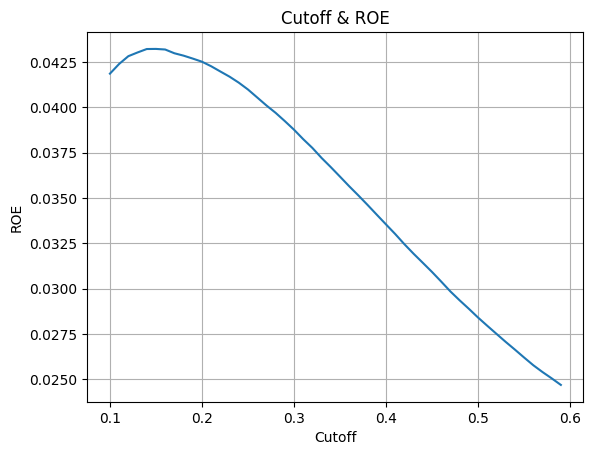

In [ ]:
list = pipeline('xgb',x,y)

In [ ]:
list

,Cut Off,ROE
0,0.10,0.041848
1,0.11,0.042383
2,0.12,0.042811
3,0.13,0.043016
4,0.14,0.043205
5,0.15,0.043211
6,0.16,0.043178
7,0.17,0.042972
8,0.18,0.042840
9,0.19,0.042678
